In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier # horrible because inbalanced classes
from sklearn.linear_model import LogisticRegression # sucks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
import shlex
import subprocess
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, TorsionFingerprints
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
from multiprocessing import Pool
import math
import timeit
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol
# from e3fp.conformers.generate import generate_conformers
from e3fp.pipeline import fprints_from_smiles
import cirpy
%run MontyCarlo.ipynb
import random
random.seed(0)

In [9]:
a = "CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O"
b = "CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[13C@H]1O"

AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(a),2,useChirality=True,nBits=2048) == AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(b),2,useChirality=True,nBits=2048)

False

In [2]:
df = pd.read_excel('SixC-Ring SMILES final chemical library v3.xlsx')
# df = pd.read_excel('SMILES final chemical library.xlsx')
df.drop(columns=df.columns[3:],inplace=True)
df.columns = ['smiles', 'names', 'label']
df['label'] = [i[0] == 'a' for i in df['label']]


bits = int(2048)

smiles = df['smiles']
names = df['names']
molecs = [Chem.MolFromSmiles(i) for i in smiles]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]
fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])


label = df['label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)




# print(df)
print(f"FULL Dataset: {df.shape}")
print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


FULL Dataset: (173, 3)
Fingerprint: (173, 2048) Sparcity: 0.01209131141618497


# Model Choice

Just for if you want to experiment with the model

In [55]:

trialsp = 1
trialsn = 1

print('SGD')

individual = lambda: make_pipeline(
    VarianceThreshold(), # this should be redundant for elasticnet regression but I'll include it anyways because it mean less multiplication by 0
    # PCA(n_components=1024),
    SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
)
# individual = lambda: SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)

for _ in range(3):

    def test_model(i):
        short_finger = list(fingerprint[:i%pos]) + list(fingerprint[(i%pos)+1:])
        model = getmodel()
        model.fit(short_finger,label[1:])
        return model.score([fingerprint[i%pos]],[1])/trialsp/pos
    correct1 = sum(map(test_model,range(trialsp*pos)))
#     print(f"model acccuracy for posatives: {correct1}")
    def test_model(i):
        short_finger = list(fingerprint[:pos+(i%neg)]) + list(fingerprint[pos+1+(i%neg):])
        model = getmodel()
        model.fit(short_finger,label[:-1])
        return model.score([fingerprint[pos+(i%neg)]],[0])/trialsn/neg
    correct0 = sum(map(test_model,range(trialsn*neg)))
#     print(f"model acccuracy for negatives: {correct0}")
    ppv = correct1*pos/(correct1*pos+(1-correct0)*neg)
#     print(f"P(1 | predict 1) = P(predict 1 | 1) P(1) / P(predict 1) = {ppv}")
    print(f"#  {len(fingerprint[0])}: ({round(correct1,2)}, {round(correct0,2)}, {round(ppv,2)})")




print('done!')

SGD
#  2048: (0.2, 1.0, 1.0)
#  2048: (0.2, 1.0, 1.0)
#  2048: (0.1, 1.0, 1.0)
done!


In [56]:
model_generator = lambda: make_pipeline(
    VarianceThreshold(),
#     PCA(n_components=50),
    SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
)

measurements = 10

means = []
stds = []
truths = []
for test in range(len(label)):
    testfp = fingerprint[test,:]
    truth = label[test]
    trainfp = np.array([i for e,i in enumerate(fingerprint) if e != test])
    trainlab = np.array([i for e,i in enumerate(label) if e != test])
    print(test,'/',len(label),'Leaving out: ',names[test],'=',label[test])
    print('Training on',fingerprint.shape,'data')
    chemscore = []
    for _ in range(measurements):
        model = model_generator()
        model.fit(trainfp,trainlab)


        prediction = model.predict_proba([testfp])[0][1]
        chemscore.append(prediction)
    means.append(np.mean(chemscore))
    stds.append(np.std(chemscore))
    truths.append(truth)
    print('Mean Error:',round(label[test] - np.mean(chemscore),4),'Std:',round(np.std(chemscore),3))
print('Done!')

0 / 173 Leaving out:  Meglumine = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
1 / 173 Leaving out:  D-(+)-Mannose = True
Training on (173, 2048) data
Mean Error: 0.9999 Std: 0.0
2 / 173 Leaving out:  sn-Glycerol 3-phosphate bis(cyclohexylammonium) salt = True
Training on (173, 2048) data
Mean Error: 0.9997 Std: 0.001
3 / 173 Leaving out:  1-Deoxy-1-morpholino-D-fructose = True
Training on (173, 2048) data
Mean Error: 0.1952 Std: 0.39
4 / 173 Leaving out:  D-Fructose 6-phosphate dipotassium salt = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
5 / 173 Leaving out:  D-(-)-Fructose = True
Training on (173, 2048) data
Mean Error: 0.4663 Std: 0.474
6 / 173 Leaving out:  D-(+)-Turanose = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
7 / 173 Leaving out:  D-(+)-Glucose = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
8 / 173 Leaving out:  D-Glucamine = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
9 / 173 Leaving out:  2-Deoxy-D

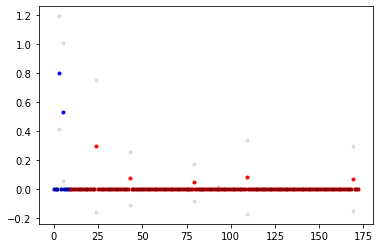

In [57]:
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if j]),'.',color='blue')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if not j]),'.',color='red')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.show()

(173, 2048)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'UMAP')

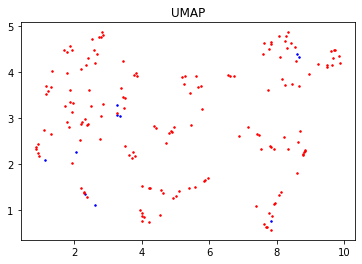

In [58]:
import umap.umap_ as umap
# import numba

# @numba.njit()
# def tanimoto_d(u, v):
#     return 1 - sum([i*j for i,j in zip(u,v)]) / sum([i+j - i*j for i,j in zip(u,v)])
print(fingerprint.shape)
embedding_umap = umap.UMAP(metric='cosine').fit_transform(PCA(n_components=30).fit_transform(fingerprint))
fig = plt.figure()
ax = plt.axes()
ax.plot(*embedding_umap[:pos].T, "b.", markersize=3)
ax.plot(*embedding_umap[pos:].T, "r.", markersize=3)
ax.set_title('UMAP')


# Log loss unbalanced SGD performed the best.

chiral morgon fingerprint with 2048 bits on an comittee of 10 unbalanced SGD linear classifiers with elasticnet loss

In [7]:
%run MontyCarlo.ipynb
# successes = 3 close, 5
gone = 7# 1, 5, 7
# gone = smiles.index('')
print(f"{names[gone]}:\t{smiles[gone]}")

individual = lambda x: SGDClassifier(random_state=x,loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
getmodel = lambda: VotingClassifier([(str(i),individual(i)) for i in range(10)], voting= 'soft', n_jobs=-1)

short_finger = list(fingerprint[:gone]) + list(fingerprint[gone+1:])
short_label = list(label[:gone]) + list(label[gone+1:])
model = getmodel()
print("model ready!")
# model.fit(short_finger,short_label)
model.fit(fingerprint,label)

# models = [(str(i),SGDClassifier(random_state=i,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet')) for i in range(10)]
# model = VotingClassifier(models, voting= 'soft', n_jobs=-1)
# # model = SGDClassifier(random_state=0,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet',n_jobs=-1)
# model.fit(short_finger,[i for i in label if i != gone])
print("fit model!")

creativity = 0
def model_on_list(x):
    result = []
    for s in x:
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,useChirality=True,nBits=bits)])
        result.append(model.predict_proba(fingerprint)[0][1]*(1-creativity)+0.5*creativity)
    return result
pred = (model_on_list([smiles[gone]])[0] -0.5*creativity)/(1-creativity)
print(f"prediction: {round(pred,2)}")

pcut = 0.5
rollouts = 100
if pred < pcut:
    print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE\t= ",round(pred,2))
    
print("running monty carlo search...")
min_molecule = mcts(
    smiles[gone],
    model_on_list,
    rollouts, # number of rollouts
    pcut, # probability cutoff
)

template = Chem.MolFromSmiles(smiles[gone])
AllChem.Compute2DCoords(template)
for i,n in enumerate(min_molecule):
    print(f"Submolecule {i}:\tScore = {round(n[0],2)}\t{n[1]}")
mMols = [Chem.MolFromSmiles(smiles[gone])] + [Chem.MolFromSmiles(m[1]) for m in min_molecule]

if pred < pcut:
    print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))
    
print('Done!')

D-(+)-Glucose:	O[C@H]1[C@H](O)[C@@H](O)C(O)O[C@@H]1CO
model ready!
fit model!
prediction: 0.99
running monty carlo search...
Submolecule 0:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 1:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 2:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 3:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 4:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 5:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 6:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 7:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 8:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 9:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 10:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 11:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 12:	Score = 0.62	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 13:	Score = 0.62	OC[C@H]1OC(

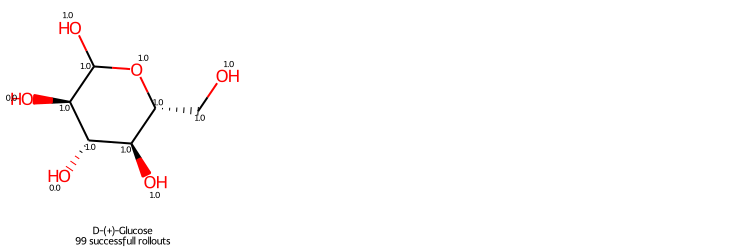

In [8]:
# Draw.MolsToGridImage(mMols,legends=[names[gone] + f': {rollouts} rollouts']+[f'Submolecule {i}' for i,j in enumerate(min_molecule)], subImgSize=(250,250), useSVG=False)

fragments = [mMols[0].GetSubstructMatch(m) for m in mMols[1:]]
for at in mMols[0].GetAtoms():
    overlaps = [at.GetIdx() in f for f in fragments]
    at.SetProp('atomNote',f"{round(sum(overlaps)/len(overlaps),2)}")
    
main_mol = mMols[0]
# print(f"{smiles[gone]}")
# print(f"{names[gone]}")
# print(f"{len(fragments)} rollouts")
# Draw.MolsToGridImage(mMols,legends=[names[gone]]+[f'Submolecule {i+1}/{len(fragments)}' for i in range(len(mMols)-1)], subImgSize=(250,250), useSVG=False)
Draw.MolsToGridImage(mMols[:1],legends=[names[gone]+f"\n{len(fragments)} successfull rollouts"], subImgSize=(250,250), useSVG=False)
# main_mol

# Scoring Similar to Glucose

In [4]:
# df = pd.read_excel('Test Set - Similar to Glucose.xlsx', dtype=str)
# supplier = 'SantaCruztBioTech'
# supplier = 'BioSynth'
# df = pd.read_csv(supplier+'StockListCarbohydratesFiltered_v3.csv', dtype=str)
supplier = 'AkosSamples'
df = pd.read_excel(supplier+'.xls', dtype=str)
df.columns = ['SMILES','Name'] + ['junk' for i in range(len(df.columns)-2)]
blacklist = ['.','2H','3H','11C','12C','13C','14C','15O','15N']
# blacklist = []
df = df[[all([b not in i for b in blacklist]) for i in df['SMILES']]]
df = df[['nan' != str(i) for i in df['Name']]]

individual = lambda i: make_pipeline(
    VarianceThreshold(),
    SGDClassifier(random_state=i,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet')
)

models = [(str(i),individual(i)) for i in range(100)]
model = VotingClassifier(models, voting= 'soft',n_jobs=-1)
print('Training model!')
model.fit(fingerprint,label)
print('Model trained!')

# print(df)
def run_on_one(s):
    s = Chem.MolFromSmiles(s)
    if s == None:
        return 0
    else:
        return model.predict_proba([AllChem.GetMorganFingerprintAsBitVect(s,2,useChirality=True,nBits=bits)])[0][1]
def model_on_list(x):
    pool = Pool(16)
    result = list(pool.map(run_on_one,x))
    pool.close()
    pool.join()
    return result

train_reslt = model_on_list(smiles)
predictions = np.array(train_reslt) - np.array(label)
print('Largest error on training data:',max(abs(predictions)))


inp = list(df['SMILES'])
predictions = list(zip(model_on_list(inp),df['Name'],df['SMILES']))
predictions = [(float(i),str(j),str(k)) for i,j,k in predictions]
predictions.sort(reverse=True)

plt.plot([i[0] for i in predictions])
plt.show()

Training model!
Model trained!
Largest error on training data: 0.003227028303424362


KeyboardInterrupt: 

In [ ]:
posatives = [i for i in predictions if i[0] > 0.5]
print('Hits:',len(posatives))
x = pd.DataFrame(posatives)
x.columns=['Score','Name','SMILES']
# x.to_excel('GlucoseLikeHits.xlsx',index=False)
x.to_excel(supplier+'Hits.xlsx',index=False)

mMols = [Chem.MolFromSmiles(m[2]) for m in posatives]
x = Draw.MolsToGridImage(mMols,legends=[f'Molecule {x}\tScore = {round(i[0],2)}\n{i[1]}' for x,i in enumerate(posatives)], molsPerRow=9, maxMols = 100, subImgSize=(300,300), returnPNG=False)
# x.save('GlucoseLikeHits.png')
x.save(supplier+'Hits.png')

Hits: 0
Empty DataFrame
Columns: []
Index: []


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
%run MontyCarlo.ipynb



creativity = 0
def model_on_list(x):
    result = []
    for s in x:
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,useChirality=True,nBits=bits)])
        result.append(model.predict_proba(fingerprint)[0][1]*(1-creativity)+0.5*creativity)
    return result

rollouts = 100

print("running monty carlo searches...")

main_mols = []
legends = []
for i, (score, name, smile) in enumerate(posatives):

    pred = (model_on_list([smile])[0] -0.5*creativity)/(1-creativity)
    print(f"prediction: {round(pred,2)}")

    min_molecule = mcts(
        smile,
        model_on_list,
        rollouts, # number of rollouts
        0.5, # probability cutoff
    )

    mMols = [Chem.MolFromSmiles(smile)] + [Chem.MolFromSmiles(m[1]) for m in set(min_molecule)]


    # for this, itself counts as a substructure
    fragments = [mMols[0].GetSubstructMatch(m) for m in mMols]
    for at in mMols[0].GetAtoms():
        overlaps = [at.GetIdx() in f for f in fragments]
        at.SetProp('atomNote',f"{round(sum(overlaps)/len(overlaps),2)}")

    main_mols.append(mMols[0])
    legends.append(name+f"\n{len(fragments)} minimal smiles found")
    print(f"{i} / {len(posatives)}")
x = Draw.MolsToGridImage(main_mols,legends=legends, molsPerRow=9, maxMols = 100, subImgSize=(300,300), returnPNG=False)
# x.save('GlucoseLikeHitsSubhits.png')
x.save(supplier+'LikeHitsSubhits.png')


running monty carlo searches...
prediction: 1.0
0 / 2
prediction: 0.96
1 / 2
